In [1]:
import kaleido
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
import plotly.graph_objects as go
import plotly.io as pio
from copy import deepcopy
from scipy.linalg import pinv
import random

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



In [2]:
print('what the hell is going on?')

#%%
#dta = pd.read_csv('/Users/hugobarette/Documents/Uni/Summer_project/Code_and_data/eurusd.csv')

dta2 = pd.read_csv('/Users/hugobarette/Documents/Uni/Summer_project/InflationData/fredmd_transf_df.csv')
dta2_A = dta2["RPI"].to_numpy()
#dta2_A = dta2_A[:100000]
rpi = dta2_A.reshape(1, len(dta2))

#lambda function to calc the returns
ret = lambda x : (x[0, 1:] - x[0, :-1]) / x[0, :-1]

# calculate the return and store in variable 
exog = ret(rpi).reshape(1, rpi.shape[1] -1 ) #these are the results, not using the same stuff as previous years wrt the lag matrix

#initialise normalised array of correct size
norm_exog = np.zeros((1, exog.shape[1])) #why does this require two brackets??

#normalise the target variable 
for i in range(2, exog.shape[1]):
    norm_exog[0, i-2] = (exog[0, i-1] - exog[0, :i].mean())/exog[0, :i].std()
#have normalised observations now.... the normalisation is rolling
endog = norm_exog

#next we need the features dataset
dta2 = dta2.drop(columns = ['RPI', 'date']) #drop unnecessary columns

#fill na
dta2 = dta2.fillna(0)

#create empty arrays
norm_dta2 = np.zeros((dta2.shape[0], dta2.shape[1] -1))
norm_dta2 = pd.DataFrame(norm_dta2)


#creates the normalised features matrix
for n in range(0, 125):
    for i in range(2, dta2.shape[0]):
        #iloc is row, column
        norm_dta2[n][i-2] = (dta2.iloc[i-1, n] - dta2.iloc[:i, n].mean())/dta2.iloc[:i,n].std()

#necessary to drop first line
norm_dta2 = norm_dta2[:][1:].fillna(0)
        
norm_dta2 = np.array(norm_dta2.T) 
# first section test
print('data imported and normalised')


what the hell is going on?


/var/folders/ml/qcbmh9rd3gxctcmwxynhzs8r0000gn/T/ipykernel_18476/4013284581.py:41: RuntimeWarning: invalid value encountered in double_scalars
  norm_dta2[n][i-2] = (dta2.iloc[i-1, n] - dta2.iloc[:i, n].mean())/dta2.iloc[:i,n].std()


data imported and normalised


In [3]:
## generates features ##

class GaussianRFF():

    def __init__(self,d,D,kernel_var=1, seed=True):
        if seed == True:
            np.random.seed(0)
        self.A = np.random.normal(loc=0,scale=kernel_var,size=(d,D)) #normal between 0 and 1
        self.b = np.random.uniform(low=0,high=2*np.pi,size=(D,1)) #uniform between 0 and 2pi
        self.D = D

    def transform(self, x):
        """
        x - feature vector (d x 1)
        z - rff feature vector (D x 1)
        """
        temp = (self.A.T @ x + self.b)
        z = np.sqrt(2/self.D) * np.cos(temp)
        return z

In [4]:
## Givens Rotation ##

import numpy as np

def Givens_Rotation(R):
    n = len(R)
    Q = np.identity(n)
    for j in range(R.shape[1]):
        for i in range(j+1,n):
            x=R[j][j]
            y=R[i][j]
            r=np.sqrt(x**2+y**2)
            if r!=0:
              c = x/r
              s = -y/r
              I = np.identity(n)
              I[i,i] = c
              I[j,j] = c
              I[i,j] = s
              I[j,i] = -s
              Q = Q@I.T
              R = I@R
    
    #return R[:n,:]
    return Q,R

In [5]:
# last row givens #

import numpy as np
from copy import deepcopy

def givens(self, update=True):

    # this section is run if we are updating
    if update:
        A = self.A
        if A.shape[0] > A.shape[1]:
            diag = A.shape[1]-1

        else:
            diag = A.shape[0]-1

        G = np.identity(A.shape[0])
        all_Q = deepcopy(self.all_Q)
        all_Q = np.concatenate((all_Q,np.zeros((all_Q.shape[0],1))),axis=1)
        all_Q = np.concatenate((all_Q,np.zeros((1,all_Q.shape[1]))),axis=0)
        all_Q[-1,-1] = 1
        Q = deepcopy(G)

        for i in range(diag):
            x = A[i,i]
            y = A[-1,i]
            r = np.sqrt(x**2 + y**2)
            c = x / r
            s = -y / r
            G[i,i] = c
            G[-1,-1] = c
            G[i,-1] = -s
            G[-1,i] = s
            A = G @ A
            Q = Q @ G.T
            G = np.identity(A.shape[0])

        self.all_Q = all_Q @ Q
        return Q.T,A

    # this section is run if we are deleting - giving problems in the QrRLS code...
    else:

        P = self.P
        G = np.identity(P.shape[1])
        G_all = deepcopy(G)
        diag = P.shape[1]-1
        A = self.A
        q = self.all_Q[0,:].reshape(self.all_Q.shape[1],1)

        for i in range(diag,0,-1):
            x = q[0,0]
            y = q[i,0]
            r = np.sqrt(x**2 + y**2)
            c = x / r
            s = -y / r
            G[i,i] = c
            G[0,0] = c
            G[0,i] = -s
            G[i,0] = s
            A = G @ A
            G_all = G_all @ G.T
            q = G @ q
            G = np.identity(self.all_Q.shape[0])

        self.all_Q = self.all_Q @ G_all

        return G_all

       

In [69]:
class QrRlS:

    def __init__(self,x,y,max_obs,ff, l):

        """
        x - Initial input Dataset
        y - Initial output Dataset
        max_obs = Rolling window size
        ff = Forgetting factor
        l = lambda(regularization term)
        """

        self.X = x
        self.y = y
        self.dim = len(x)
        self.I = np.eye(self.dim)
        ff = np.sqrt(ff)
        self.ff = ff
        self.l = l
        self.b = 1
        
        # Forgetting factor matrix
        B = np.diag([ff**i for i in range(x.shape[1]-1,-1,-1)])
        self.X = self.X @ B
        self.n_batch = x.shape[1]
        self.Q, self.R = Givens_Rotation(self.X.T)
        self.R_inv = pinv(self.R)
        self.w = self.R_inv @ self.Q.T @ y
        self.z = self.Q.T @ y

        # A and P were used as R and R inverse
        self.A = self.R
        self.P = self.R_inv
        self.max_obs = max_obs
        self.all_Q = deepcopy(self.Q)
        self.i = 1
        
    def update(self,x,y,err):
        
        #adaptive forgetting factor piece 
        e_base = 1 #constant - error magnitude
        h = 0.9 #constant - sensitivity
        lambda_min = 0.9 #constant - minimum forgetting factor 
        eps_k = round((err/e_base)**2) # first epsilon variable 
        self.ff = lambda_min + (1-lambda_min)*(h**eps_k) #new forgetting factor
        
        if self.ff != 1:
            print(self.ff)
        
        self.X = np.c_[self.X, x]
        self.y = np.r_[self.y,y]
        nobs = np.shape(self.X)[1]
        self.P = (1/self.ff)*self.P
        self.A = self.ff * self.A
        d = x.T @ self.P
        c = x.T @ (np.eye(self.A.shape[1]) - self.P @ self.A)

        # Update for new regime
        if not np.allclose(0,c):
            c_inv = pinv(c)
            self.P = np.c_[self.P - c_inv @ d, c_inv]

        # Update for old regime
        else:
            b_k = 1/(1 + d @ d.T) * self.P @ d.T
            self.P = np.c_[self.P - b_k @ d, b_k]

        self.A = np.r_[self.A, x.T]
        self.Q,self.A = givens(self)
        y = np.array(self.y).reshape(self.X.shape[1],1)
        self.w = self.P @ y
        self.P = self.P @ self.Q.T
        self.i += 1
        
        if nobs > self.max_obs:
            x = self.X[:,0].reshape(self.dim, 1)
            self.delete(x, self.y[0])


    def delete(self,x,y):

        """
        x - features which will get deleted (dim x 1)
        y - target which will get deleted (scalar)
        """

        temp = np.allclose(np.eye(self.A.shape[1]), self.A.T @ self.P.T)
        self.X = self.X[:, 1:]
        self.Q = givens(self, False)
        self.P = self.P @ self.Q
        self.A = self.Q.T @ self.A
        x = self.A[0,:].reshape(self.dim, 1)
        c = np.zeros((self.P.shape[1], 1))
        c[0, 0] = 1
        k = self.P @ c
        h = x.T @ self.P
        je = x.T @ self.P @ c

        # Deletion for new regime
        if not temp:
            self.P = self.P - k @ pinv(k) @ self.P - self.P @ pinv(h) @ h + (pinv(k) @ self.P @ pinv(h)) * k @ h
            # this line causing issues in the QrRLS bagging - k or h are inf

        # Deletion for old regime
        else:
            x = -x
            h = x.T @ self.P
            u = (np.eye(self.P.shape[1]) - self.A @ self.P) @ c
            k = self.P @ c
            h_mag = h @ h.T
            u_mag = u.T @ u
            S = (1 + x.T @ self.P @ c)
            p_2 = - ((u_mag)/S * self.P @ h.T) - k
            q_2 = - ((h_mag)/S * u.T - h)
            sigma_2 = h_mag * u_mag + S**2
            self.P = self.P + 1/S * self.P @ h.T @ u.T - S/sigma_2 * p_2 @ q_2
        
        self.P = self.P[:,1:]
        self.A = self.A[1:,:]
        y = np.array(self.y).reshape(self.X.shape[1]+1,1)
        y = self.all_Q.T @ y
        y = y[1:]
        self.w = self.P @ y
        self.all_Q = self.all_Q[1:,1:]
        self.y = self.y[1:]


    def pred(self,x):
        """
        x - features (dim x 1)
        """
        
        if x.shape[1] == 1:
            pred = (x.T @ self.w).item()
            
        else:
            pred = x.T @ self.w
        return pred

    

In [8]:
##ok so have endog and norm_dta2 in df and not transposed, features in columns - easier to imagine 
# now to produce a bagging regime
# first step is to get the features we need for each regime.... 

D = 1024
sigma = 1
batch_s = 30

def sampling(X, Y, n_bags, feature_sample_number, roll_size, n, overlap=False):
    
    features_array = [] #array to hold feature indices 
    data_array = [] # array to hold data indices 
    bags = [] #holds the bags
    targets = [] #holds the Y values 
    lags = X.shape[1] #length of the dataset
    length = X.shape[0]  # columns of the dataset
    test_feat = np.arange(0, D) #total features
    used_feat = [] #used feature array
    
    feature_list = range(0, X.shape[1]) #list of features for checking 
    
    if not overlap:
    
        # need to generate the bags from our RFF features 
        for i in range(0, n_bags):

            #feature_sampling
            features = np.sort(random.sample(range(0, X.shape[1]), feature_sample_number))
            features_array.append(features)

            #data sampling
            start_index = random.choice(range(0, (X.shape[0] - roll_size + n)))
            end_index = start_index + roll_size + n #data only has to be rolling_window + n predictions in length

            #target_sampling 
            targets.append(Y[0][:])

            #[columns][rows]..... .iloc[rows, columns]
            bags.append(np.array(X[:, features]))

        #check 
        unused_feat = [n for n in feature_list if n not in np.concatenate(features_array, 0)]

        #if len(unused_feat) == 0:
        #    print('all features used')
        #else: 
        #    print('use more bags or increase feature number')

            
    if overlap:
        
        #first need to generate the required number of features for overlap 
        overlap_features = np.sort(random.sample(range(0, X.shape[1]), int(overlap*feature_sample_number))) 
        
        feature_list = [i for i in feature_list if i not in overlap_features]
        
        for i in range(0, n_bags):

            #feature_sampling
            features = np.sort(random.sample(range(0, X.shape[1]), feature_sample_number - int(overlap*feature_sample_number)))
            features_array.append(features)
            features_array[i] = np.concatenate((features_array[i], overlap_features))

            #data sampling
            #start_index = random.choice(range(0, X.shape[0] - (roll_size + n)))
            #end_index = start_index + roll_size + n #data only has to be rolling_window + n predictions in length

            #target_sampling 
            targets.append(Y[0][:])
            #[columns][rows]..... .iloc[rows, columns]
            bags.append(np.array(X[:, features_array[i]]))

        #check 
        feature_list = range(0, X.shape[1]) #need original features list
        unused_feat = [n for n in feature_list if n not in np.concatenate(features_array, 0)]
        
        #if len(unused_feat) == 0:
        #    print('all features used')
        #else: 
        #    print('use more bags or increase feature number')
        
    return features_array, data_array, bags, targets, X

In [21]:
#sampling(X, Y, n_bags, feature_sample_number, roll_size, n, overlap=False):

features_array, data_array, bags, targets, X = sampling(norm_dta2[:, :30], endog, 1, 30, 30, 20, overlap = False)

all features used


In [203]:
len(bags)

10

In [52]:
def QRRLS_bagging(X, Y, D, sigma, n, ff, l, roll_size, batch_s, n_bags, feature_num, overlap=False): 
    #defining an QRRLS function
    
    #batch_s = 30
    lags = X.shape[0] #length of the dataset
    all_bags_preds = []
    all_bags_mse = []
    all_bags_mean_mse = []
    models = []
    
    #first step is to RFF the features 
    rff = GaussianRFF(lags, D, sigma)
    
    #initialise everything by making a single prediction 
    X_trans = rff.transform(X[:, :batch_s].reshape(lags, batch_s)) #needs to be batch + n window size
    X_trans = X_trans.T
        
    features_array, data_array, bags, targets, X_trans = sampling(X_trans, Y, n_bags, feature_num, 
                                                                      roll_size, n, overlap)
    #print(len(bags))
    for p in range(0, n_bags):

        mod_QRRLS = QrRlS(bags[p].T[:, :batch_s], # I think no reshape needed here....
                        targets[p].T[:batch_s],  # y - this is the observations dataset
                        roll_size,  # max_obs - normal variable
                        ff,  # forgetting factor
                        l)
        models.append(mod_QRRLS)

        #preds_QRRLS = [mod_QRRLS.pred(bags[p][batch_s].reshape(feature_num, 1))]

        preds_QRRLS = bags[p][batch_s - 1].reshape(feature_num, 1)

        # classic predictions array
        mse_QRRLS = [(preds_QRRLS[0] - targets[p][batch_s - 1]) ** 2]
        all_bags_mse.append(mse_QRRLS)
    
    err = 0
    #time step loop has to be the outermost loop
    for i in range(0, n-1):
    
        X_trans = rff.transform(X[:, :batch_s + i].reshape(lags, batch_s + i))
        X_trans = X_trans.T
        
        features_array, data_array, bags, targets, X_trans = sampling(X_trans, Y, n_bags, feature_num, 
                                                                      roll_size, n, overlap)
        #print(len(bags))
        for p in range(0, n_bags):
            
            u = bags[p][batch_s + i - 1].reshape(feature_num, 1)  # reshape feature vector
            d = targets[p][batch_s + i - 1] #d holds the results of the data
            models[p].update(u, d, err) #update the model
            
            #make predictions 
            preds_QRRLS = [models[p].pred(bags[p][batch_s + i - 1].reshape(feature_num, 1))] #model makes prediction
        
            # classic predictions array
            mse_QRRLS = [(preds_QRRLS[0] - targets[p][batch_s + i - 1]) ** 2]
            
            #error calculation
            err = preds_QRRLS[0] - targets[p][batch_s + i - 1]
            
            #save mean mse
            all_bags_mse[p].append(mse_QRRLS)
            
    for i in range(0, n_bags):
        all_bags_mean_mse.append(np.mean(all_bags_mse[i]))
        
    return all_bags_mean_mse


In [72]:
D = 1024
sigma = 1
n = 20
ff = 1
l = 0
roll_size = 30
batch_s = 30
round_start = 0
rounds = 4
overlap = False

#QRRLS_bagging(X, Y, D, sigma, n, ff, l, roll_size, batch_s, n_bags, feature_num, overlap=False): 
mse = QRRLS_bagging(norm_dta2, endog, D, sigma, n, ff, l, roll_size, batch_s, 10, 40, overlap)

In [60]:
np.mean(mse)

0.003980327140486385

round  1 , overlap  0 , bag_num  10 , complete in  1.659985065460205
round  1 , overlap  0 , bag_num  20 , complete in  3.300041913986206
round  1 , overlap  0.1 , bag_num  10 , complete in  1.759495735168457
round  1 , overlap  0.1 , bag_num  20 , complete in  3.1450397968292236
round  1 , overlap  0.2 , bag_num  10 , complete in  1.7610530853271484
round  1 , overlap  0.2 , bag_num  20 , complete in  2.8430697917938232
round  1 , overlap  0.3 , bag_num  10 , complete in  1.9549717903137207
round  1 , overlap  0.3 , bag_num  20 , complete in  3.63263201713562

complete


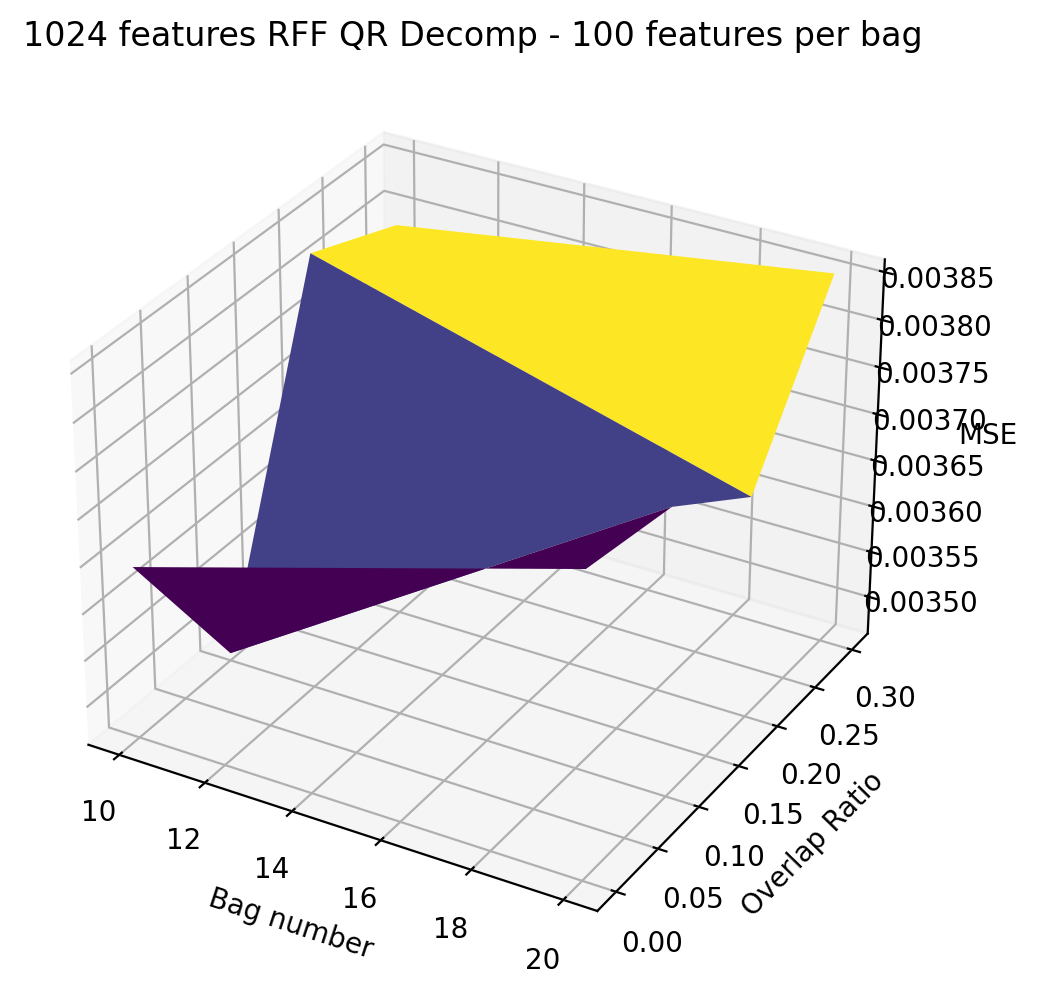

In [230]:
D = 4096
sigma = 1
n = 20
ff = 1
l = 0
roll_size = 30
batch_s = 30
round_start = 0
rounds = 2
overlap = False
mse_array = []
bag_num = [10, 20]#, 50, 100, 150, 200] #, 500]
overlap_array = [0, 0.1, 0.2, 0.3]#, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

X1, Y1 = np.meshgrid(bag_num, overlap_array)

#QRRLS_bagging(X, Y, D, sigma, n, ff, l, roll_size, batch_s, n_bags, feature_num, overlap=False): 

for q in overlap_array:
    mse_array_temp = []
    for p in bag_num:
        start = time.time()
        mse = QRRLS_bagging(norm_dta2, endog, D, sigma, n, ff, l, roll_size, 
                            batch_s, p, 100, q)
        mse_array_temp.append(np.mean(mse))
        print('round ', k , ', overlap ', q, ', bag_num ', p, ', complete in ', time.time() - start)
    mse_array.append(mse_array_temp)
print('')
    
print('complete')
    

fig1 = plt.figure(figsize = (15, 6), dpi = 200)
ax1 = plt.axes(projection = '3d')
#X1, Y1 = np.meshgrid(x_vals, mse_array)
ax1.plot_surface(X1, Y1, np.array(mse_array), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
#plt.plot(x_vals, mse_array, 'o-')
#plt.ylim([0, np.max(mse_array)*1.1])
ax1.set_xlabel('Bag number')
ax1.set_ylabel('Overlap Ratio')
ax1.set_zlabel('MSE')
ax1.set_title('1024 features RFF QR Decomp - 100 features per bag')
plt.savefig('bags_overlap_3d.jpg', bbox_inches = 'tight')

plt.show()    

AttributeError: 'numpy.ndarray' object has no attribute 'index'

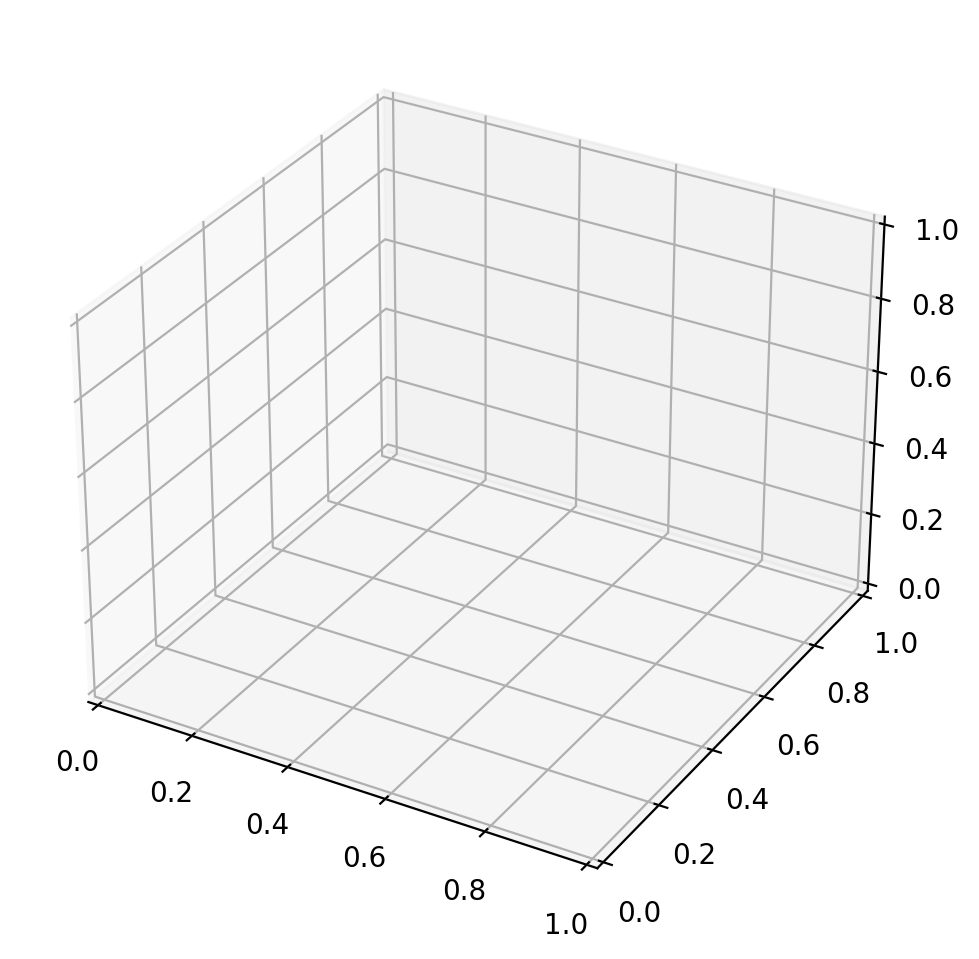

In [222]:
fig1 = plt.figure(figsize = (15, 6), dpi = 200)
ax1 = plt.axes(projection = '3d')
#X1, Y1 = np.meshgrid(x_vals, mse_array)
ax1.plot_wireframe(X1, Y1, np.array(mse_array), color='black')
#plt.plot(x_vals, mse_array, 'o-')
#plt.ylim([0, np.max(mse_array)*1.1])
ax1.set_xlabel('Bag number')
ax1.set_ylabel('Overlap Ratio')
ax1.set_zlabel('MSE')
ax1.set_title('1024 features RFF QR Decomp - 100 features per bag')
plt.savefig('bags_overlap_3d.jpg', bbox_inches = 'tight')

plt.show()    

In [247]:
zmax = np.max(mse_array)
mse_array.index(max(mse_array[:][:]))
#print(zmax, ' ', mse_array[3][1])
#xpos = X1.index(zmax)
#xmax = X1[xpos]#

#ypos = Y1.index(zmax)
#ymax = Y1[xpos]

2

In [239]:
mse_array

[[0.0036432685169801556, 0.003781179833198877],
 [0.0034670596546550825, 0.0037640636913760525],
 [0.0038250158253756465, 0.0036960338187597376],
 [0.003786219226864268, 0.003855007372147567]]

In [217]:
#this kernel does different RFF expansions
# rff expansion has to be greater than feature number within bags 

D = 1024
D_array = [15, 50, 100, 200, 500, 1000]
sigma = 1
n = 20
ff = 1
l = 0
roll_size = 30
batch_s = 30
round_start = 0
rounds = 2
overlap = False
mse_array = []
bag_num = [10, 20, 50, 100, 150, 200] #, 500]
#overlap_array = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

X1, Y1 = np.meshgrid(bag_num, D_array)

#QRRLS_bagging(X, Y, D, sigma, n, ff, l, roll_size, batch_s, n_bags, feature_num, overlap=False): 

for q in D_array:
    mse_array_temp = []
    for p in bag_num:
        start = time.time()
        mse = QRRLS_bagging(norm_dta2, endog, q, sigma, n, ff, l, roll_size, 
                            batch_s, p, 30, overlap)
        mse_array_temp.append(np.mean(mse))
        print('D ', q, ', bag_num ', p, ', complete in ', time.time() - start)
    mse_array.append(mse_array_temp)
print('')
    
print('complete')
    

fig1 = plt.figure(figsize = (15, 6), dpi = 200)
ax1 = plt.axes(projection = '3d')
#X1, Y1 = np.meshgrid(x_vals, mse_array)
ax1.plot_surface(X1, Y1, np.array(mse_array), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
#plt.plot(x_vals, mse_array, 'o-')
#plt.ylim([0, np.max(mse_array)*1.1])
ax1.set_xlabel('Bag number')
ax1.set_ylabel('RFF Number')
ax1.set_zlabel('MSE')
ax1.set_title('No overlap - 30 features per bag')
plt.savefig('bags_RFF_3d.jpg', bbox_inches = 'tight')

plt.show()    

D  15 , bag_num  10 , complete in  0.1369800567626953
D  15 , bag_num  20 , complete in  0.22711491584777832
D  15 , bag_num  50 , complete in  0.554373025894165
D  15 , bag_num  100 , complete in  1.08675217628479
D  15 , bag_num  150 , complete in  1.5960850715637207
D  15 , bag_num  200 , complete in  2.116848945617676
D  50 , bag_num  10 , complete in  0.1227262020111084
D  50 , bag_num  20 , complete in  0.36620497703552246
D  50 , bag_num  50 , complete in  0.5973169803619385
D  50 , bag_num  100 , complete in  1.1186439990997314
D  50 , bag_num  150 , complete in  1.6692731380462646


KeyboardInterrupt: 

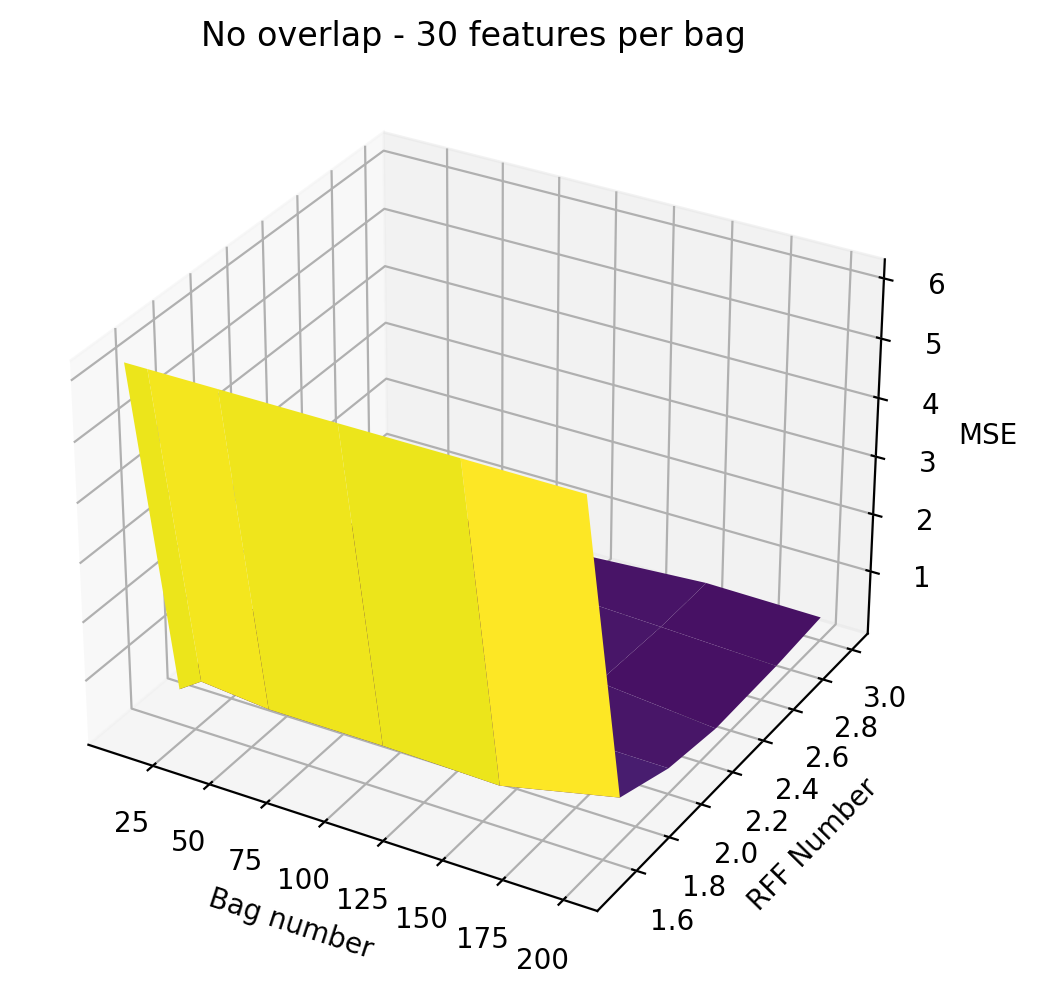

In [214]:
fig1 = plt.figure(figsize = (15, 6), dpi = 200)
ax1 = plt.axes(projection = '3d')
#X1, Y1 = np.meshgrid(x_vals, mse_array)
ax1.plot_surface(X1, np.log10(Y1), np.array(mse_array), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
#plt.plot(x_vals, mse_array, 'o-')
#plt.ylim([0, np.max(mse_array)*1.1])
ax1.set_xlabel('Bag number')
ax1.set_ylabel('RFF Number')
ax1.set_zlabel('MSE')
ax1.set_title('No overlap - 30 features per bag')
plt.savefig('bags_RFF_3d.jpg', bbox_inches = 'tight')

plt.show() 

In [149]:
X

array([[-6.        , -5.5862069 , -5.17241379, -4.75862069, -4.34482759,
        -3.93103448, -3.51724138, -3.10344828, -2.68965517, -2.27586207,
        -1.86206897, -1.44827586, -1.03448276, -0.62068966, -0.20689655,
         0.20689655,  0.62068966,  1.03448276,  1.44827586,  1.86206897,
         2.27586207,  2.68965517,  3.10344828,  3.51724138,  3.93103448,
         4.34482759,  4.75862069,  5.17241379,  5.5862069 ,  6.        ],
       [-6.        , -5.5862069 , -5.17241379, -4.75862069, -4.34482759,
        -3.93103448, -3.51724138, -3.10344828, -2.68965517, -2.27586207,
        -1.86206897, -1.44827586, -1.03448276, -0.62068966, -0.20689655,
         0.20689655,  0.62068966,  1.03448276,  1.44827586,  1.86206897,
         2.27586207,  2.68965517,  3.10344828,  3.51724138,  3.93103448,
         4.34482759,  4.75862069,  5.17241379,  5.5862069 ,  6.        ],
       [-6.        , -5.5862069 , -5.17241379, -4.75862069, -4.34482759,
        -3.93103448, -3.51724138, -3.10344828, -2